<a href="https://colab.research.google.com/github/DmitryMaximus/Robot/blob/master/Copy_of_Robot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Нужно:
1) Обработать столбец gamma усрединить значение в интервалах max_counter (плюс в функции NewDataFrame учесть этот случай (отбрасывается _ray))
2) Ограничить тремя стандартыми отклоненями все колонки
3) Свапнуть столбец year и индекс и запихнуть в объединенную регрессию (нужно разобраться с типом эффекта)
4) Сделать гридсерч по xgboost
5) Разобраться с инпутом в xgboost dart

> Indented block



In [0]:
#Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import sklearn
import sklearn.preprocessing
import statsmodels
import math
import time

from tqdm import tqdm

dtrain_old = pd.read_csv("https://raw.githubusercontent.com/DmitryMaximus/Robot/master/train_data.csv")
dtest_old = pd.read_csv("https://raw.githubusercontent.com/DmitryMaximus/Robot/master/test_data.csv")


dtrain_old=dtrain_old.dropna()

In [0]:
def Max_Mean_Visual (df):#визуализируем за исключением первых трех колонок
  Max_Mean={}
  for i in range(len(df.columns)):
    name=df.columns.tolist()[i]
    maximum=np.max(df.iloc[:,i])
    mean=np.mean(df.iloc[:,i])
    Max_Mean[name]=maximum,mean
  Max_Mean['index']='Max','Mean'
  Max_Mean=pd.DataFrame(Max_Mean)
  Max_Mean=Max_Mean.set_index('index')
  Max_Mean.head(5)

  red_patch = mpatches.Patch(color='red', label='Max')
  g_patch = mpatches.Patch(color='g',label='Mean')
  plt.legend(handles=[red_patch,g_patch])
  plt.bar(Max_Mean.columns.tolist()[3:], Max_Mean.iloc[0,:].values[3:], width=0.5, color='red')
  plt.bar(Max_Mean.columns.tolist()[3:], Max_Mean.iloc[1,:].values[3:], width=0.5, color='g')
  plt.xticks(Max_Mean.columns.tolist()[3:], rotation=90)
  

def Scaler_std(Data,list_of_Columns,num_of_std): #Отбор выбросов по трем стандартным отклонениям
  Data1=Data.copy()
  for element in list_of_Columns:
    Data1[np.abs(Data1[element] - Data1[element].mean()) > (2*Data1[element].std())]=num_of_std*Data1[element].std()
  return Data1

def SwapColumns(Data,Column1,Column2):#Смена колонок местами
  col_list=list(Data)
  swap1=Data[Column2].copy()
  Data[Column2]=Data[Column1]
  Data[Column1]=swap1
  position1=Data.columns.tolist().index(Column1)
  position2=Data.columns.tolist().index(Column2)
  Data.columns.values[position1]=Column2
  Data.columns.values[position2]=Column1
  return  Data
  
def NewDataFrame(Data, delim): #решейп, работает для dtrain около 3.5 минут на среднем компуктере
    #для номинальных переменных усреднения не будет(типо в одном году "low", то во всех low, но хорошо, что не вылетает)
    import progressbar
    import time
    import re
    row_length = len(Data)
    columns = list(Data)
    col_length = len(columns)
    new_columns_list = []
    colum_num = []
    for colz in range(0, col_length): #цикл по каждой колонке
        split = columns[colz].split(delim)
        new_name = ''
        if len(split[:-1]) > 1:
            colum_num.append(split[-1])
            for element in split[:-1]:
                new_name += str(delim + element)
                new_name = new_name.lstrip(delim)
        else:
            new_name = columns[colz]
        new_columns_list.append(new_name)
    new_columns_list = list(dict.fromkeys(new_columns_list))
    max_counter = max(map(int, colum_num))
    dfbig = pd.DataFrame([], columns=new_columns_list)
    new_Dict = {}
    Progress=0
    for elements in new_columns_list:
        new_Dict.update({elements: [None] * max_counter})    # создаем пустой словарь с ключами из новых столбцов
    for row in tqdm(range(0, row_length - 1)):  # идем по строке оригинального df
        for colz in range(0, col_length):  # идем по столбцам оригинального df
            for i in range(0, len(new_columns_list)):  # идем по листу новых колонок
                match = re.search(new_columns_list[i], columns[colz])
                if type(match) != type(None):  #сравниваем колонку из df с новой колонкой
                    try:
                        position = int(columns[colz].split(delim)[-1])-1
                    except ValueError:
                        position=0
                    Column_key = new_Dict.get(new_columns_list[i])
                    Column_key[position] = Data.iloc[row, colz]
                    new_Dict.update({new_columns_list[i]: Column_key})
        dfsmall = pd.DataFrame(new_Dict)
        dfsmall = dfsmall.fillna(dfsmall.mean())
        dfbig = pd.concat([dfbig, dfsmall])
        for elements in new_columns_list:
            new_Dict.update({elements: [None] * max_counter})
            
    return dfbig

In [0]:
dtrain=NewDataFrame(dtrain_old,'_')
dtest=NewDataFrame(dtest_old,'_')

100%|██████████| 999/999 [00:25<00:00, 39.46it/s]


In [0]:
# Переводим gamma_ray в категориальные - если запустить второй раз, то получим пустой вектор и сделаем колонку gamma_ray пустой


pd.unique(dtrain['gamma_ray'])#подготовка данных для тренировки
gamma_ray_cat=dtrain['gamma_ray'].map({'low':0, 'moderate':1, 'high':2})#переводим категориальные в числовые
dtrain['gamma_ray']=gamma_ray_cat

In [0]:
#Запускай эту ячейку, если хочешь начать обработку dtrain заново
dtrain_swap=dtrain.copy()
cols=dtrain_swap.columns.tolist()
swap1=cols[1]
cols[1]=cols[-2]
cols[-2]=swap1
cols=cols[-1:]+cols[:-1] 
dtrain_cols=dtrain_swap[cols]
dtrain_cols.head()
#т.е. target теперь - первая колонка, year - вторая (ее не трогали), gamma_ray - третья, остальные просто сдвинуты без изменения порядка.
dtrain_scaled=dtrain_cols.copy()
dtrain_scaled=SwapColumns(dtrain_scaled,'target','year') #свапаем колонки, чтобы 
Max_Mean_Visual(dtrain_scaled)

dtrain_scaled

,year,target,gamma_ray,sensor_robot_controller_index,sensor_robot_arm_right,robot_gear_circulation,sensor_robot_arm_left,sensor_robot_jump_power,robot_gear_coef,robot_gear_compression,...,robot_engine_speed,robot_engine_circulation,robot_engine_ground,robot_engine_compression,robot_engine_temperature,sensor_robot_eye_laser_range,robot_probe_compression_diff,robot_probe_circulation,robot_probe_temperature,robot_gear_compression_diff
0,2019.0,19.993461,0.0,0.493576,-4.783722,16.644855,-52.895679,2.698838,4.789334,12.747504,...,-5.139269,18.818453,35.790778,-20.001171,-54.647574,1.474627,-14.404337,18.463526,-32.828662,10.679910
1,2019.0,19.993461,NaN,15.091173,40.724420,10.535431,15.631746,-68.458906,4.789334,9.375580,...,-5.139269,-3.798114,35.790778,-2.722308,-48.437402,-51.691028,10.573489,0.578525,1.867720,2.485140
2,2019.0,19.993461,NaN,44.295169,2.813424,12.623599,41.220951,0.961480,4.789334,19.201325,...,-5.139269,8.568102,35.790778,6.299379,-28.928589,-25.108201,7.826896,-10.696750,-8.174186,14.274428
3,2019.0,19.993461,NaN,25.624383,12.315985,12.623599,-28.059812,45.371471,4.789334,-11.045572,...,-5.139269,96.448531,35.790778,-5.474700,9.236012,-25.108201,11.771591,13.406820,-9.845427,-11.045572
4,2019.0,19.993461,NaN,45.093450,13.822417,12.623599,15.256857,5.396570,4.789334,0.651988,...,-5.139269,18.818453,35.790778,-5.474700,-22.524206,-25.108201,-6.504728,2.569083,-19.814141,2.485140
5,2019.0,19.993461,NaN,26.119550,12.978505,38.458824,-1.769187,-2.806109,4.789334,-21.801493,...,-5.139269,-0.784865,35.790778,-5.474700,-2.869515,-25.108201,7.236562,3.074355,-25.839817,8.581814
6,2019.0,19.993461,NaN,26.119550,12.978505,12.623599,-1.769187,-2.806109,4.789334,13.683193,...,-5.139269,3.268382,35.790778,-5.474700,-54.647574,-25.108201,25.680162,0.656073,0.970255,13.683193
7,2019.0,19.993461,NaN,26.119550,12.978505,37.372011,-1.769187,-2.806109,4.789334,5.829388,...,-5.139269,9.208682,35.790778,-5.474700,-54.647574,-25.108201,16.588792,3.708103,3.238174,5.829388
8,2019.0,19.993461,NaN,26.119550,12.978505,12.623599,-1.769187,-2.806109,4.789334,-46.055115,...,-5.139269,18.818453,35.790778,-5.474700,-37.142556,-25.108201,7.495458,0.527032,1.817238,-46.055115
9,2019.0,19.993461,NaN,26.119550,12.978505,12.623599,-1.769187,-2.806109,4.789334,23.933078,...,-5.139269,18.818453,35.790778,-5.474700,-101.081233,-25.108201,21.893308,3.333452,-9.845427,23.933078


Далее используем data_train

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler #Можно заменить на MinMaxScaler, код в самом низу

data_train=dtrain_scaled[dtrain_scaled.columns.tolist()[3:]] #первые три не нормализуем
StandartScaler=StandardScaler()
MinMaxScaler=MinMaxScaler()
data_scaled=StandartScaler.fit_transform(data_train)
data_scaled=MinMaxScaler.fit_transform(data_train)
dtrain_scaled.loc[:,3:]=data_scaled

dtrain_scaled
Max_Mean_Visual(dtrain_scaled)

,year,target,gamma_ray,sensor_robot_controller_index,sensor_robot_arm_right,robot_gear_circulation,sensor_robot_arm_left,sensor_robot_jump_power,robot_gear_coef,robot_gear_compression,...,robot_engine_speed,robot_engine_circulation,robot_engine_ground,robot_engine_compression,robot_engine_temperature,sensor_robot_eye_laser_range,robot_probe_compression_diff,robot_probe_circulation,robot_probe_temperature,robot_gear_compression_diff
0,2019.0,19.993461,0.0,0.918820,0.776697,0.798153,0.570283,0.590369,0.064223,0.458926,...,0.130461,0.365642,0.375521,0.721686,0.702076,0.839158,0.628225,0.932950,0.644821,0.455139
1,2019.0,19.993461,NaN,0.941221,0.854387,0.788919,0.746806,0.458959,0.064223,0.452750,...,0.130461,0.359591,0.375521,0.737290,0.705231,0.668521,0.670164,0.921802,0.678353,0.440129
2,2019.0,19.993461,NaN,0.986036,0.789666,0.792075,0.812722,0.587161,0.064223,0.470747,...,0.130461,0.362899,0.375521,0.745437,0.715143,0.753840,0.665552,0.914774,0.668648,0.461723
3,2019.0,19.993461,NaN,0.957385,0.805889,0.792075,0.634259,0.669174,0.064223,0.415345,...,0.130461,0.386411,0.375521,0.734805,0.734534,0.753840,0.672176,0.929798,0.667033,0.415345
4,2019.0,19.993461,NaN,0.987261,0.808461,0.792075,0.745840,0.595351,0.064223,0.436771,...,0.130461,0.365642,0.375521,0.734805,0.718397,0.753840,0.641489,0.923043,0.657399,0.440129
5,2019.0,19.993461,NaN,0.958144,0.807020,0.831121,0.701982,0.580203,0.064223,0.395644,...,0.130461,0.360397,0.375521,0.734805,0.728383,0.753840,0.664561,0.923358,0.651575,0.451296
6,2019.0,19.993461,NaN,0.958144,0.807020,0.792075,0.701982,0.580203,0.064223,0.460640,...,0.130461,0.361481,0.375521,0.734805,0.702076,0.753840,0.695529,0.921850,0.677486,0.460640
7,2019.0,19.993461,NaN,0.958144,0.807020,0.829478,0.701982,0.580203,0.064223,0.446254,...,0.130461,0.363071,0.375521,0.734805,0.702076,0.753840,0.680264,0.923753,0.679677,0.446254
8,2019.0,19.993461,NaN,0.958144,0.807020,0.792075,0.701982,0.580203,0.064223,0.351219,...,0.130461,0.365642,0.375521,0.734805,0.710970,0.753840,0.664996,0.921770,0.678304,0.351219
9,2019.0,19.993461,NaN,0.958144,0.807020,0.792075,0.701982,0.580203,0.064223,0.479414,...,0.130461,0.365642,0.375521,0.734805,0.678484,0.753840,0.689170,0.923519,0.667033,0.479414


In [0]:
#В этой ячейке мы ограничиваем таргет двумя стандартными отклонениями и заменяем пустые значения gamma_ray 

for i in range(0,max(dtrain_scaled.gamma_ray.index)+1):
    dtrain_scaled.gamma_ray[i]=dtrain_scaled.gamma_ray[0]
dtrain_scaled[np.abs(dtrain_scaled.target-dtrain_scaled.target.mean()) > (2*dtrain_scaled.target.std())]=2*dtrain_scaled.target.std()
dtrain_scaled

,year,target,gamma_ray,sensor_robot_controller_index,sensor_robot_arm_right,robot_gear_circulation,sensor_robot_arm_left,sensor_robot_jump_power,robot_gear_coef,robot_gear_compression,...,robot_engine_speed,robot_engine_circulation,robot_engine_ground,robot_engine_compression,robot_engine_temperature,sensor_robot_eye_laser_range,robot_probe_compression_diff,robot_probe_circulation,robot_probe_temperature,robot_gear_compression_diff
0,2019.000000,19.993461,0.000000,0.918820,0.776697,0.798153,0.570283,0.590369,0.064223,0.458926,...,0.130461,0.365642,0.375521,0.721686,0.702076,0.839158,0.628225,0.932950,0.644821,0.455139
1,2019.000000,19.993461,0.000000,0.941221,0.854387,0.788919,0.746806,0.458959,0.064223,0.452750,...,0.130461,0.359591,0.375521,0.737290,0.705231,0.668521,0.670164,0.921802,0.678353,0.440129
2,2019.000000,19.993461,0.000000,0.986036,0.789666,0.792075,0.812722,0.587161,0.064223,0.470747,...,0.130461,0.362899,0.375521,0.745437,0.715143,0.753840,0.665552,0.914774,0.668648,0.461723
3,2019.000000,19.993461,0.000000,0.957385,0.805889,0.792075,0.634259,0.669174,0.064223,0.415345,...,0.130461,0.386411,0.375521,0.734805,0.734534,0.753840,0.672176,0.929798,0.667033,0.415345
4,2019.000000,19.993461,0.000000,0.987261,0.808461,0.792075,0.745840,0.595351,0.064223,0.436771,...,0.130461,0.365642,0.375521,0.734805,0.718397,0.753840,0.641489,0.923043,0.657399,0.440129
5,2019.000000,19.993461,0.000000,0.958144,0.807020,0.831121,0.701982,0.580203,0.064223,0.395644,...,0.130461,0.360397,0.375521,0.734805,0.728383,0.753840,0.664561,0.923358,0.651575,0.451296
6,2019.000000,19.993461,0.000000,0.958144,0.807020,0.792075,0.701982,0.580203,0.064223,0.460640,...,0.130461,0.361481,0.375521,0.734805,0.702076,0.753840,0.695529,0.921850,0.677486,0.460640
7,2019.000000,19.993461,0.000000,0.958144,0.807020,0.829478,0.701982,0.580203,0.064223,0.446254,...,0.130461,0.363071,0.375521,0.734805,0.702076,0.753840,0.680264,0.923753,0.679677,0.446254
8,2019.000000,19.993461,0.000000,0.958144,0.807020,0.792075,0.701982,0.580203,0.064223,0.351219,...,0.130461,0.365642,0.375521,0.734805,0.710970,0.753840,0.664996,0.921770,0.678304,0.351219
9,2019.000000,19.993461,0.000000,0.958144,0.807020,0.792075,0.701982,0.580203,0.064223,0.479414,...,0.130461,0.365642,0.375521,0.734805,0.678484,0.753840,0.689170,0.923519,0.667033,0.479414


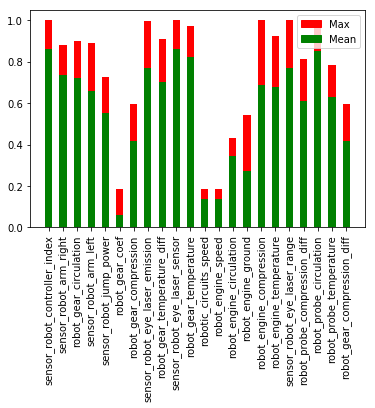

In [0]:
#В этой ячейке мы ограничиваем двумя стандартыми отклонениями все столбцы кроме Таргет, Год, и Гамма

dtrain_scaled=Scaler_std(dtrain_scaled,list(dtrain_scaled)[3:],2)
Max_Mean_Visual(dtrain_scaled)

Text(0, 0.5, 'robot_gear_temperature')

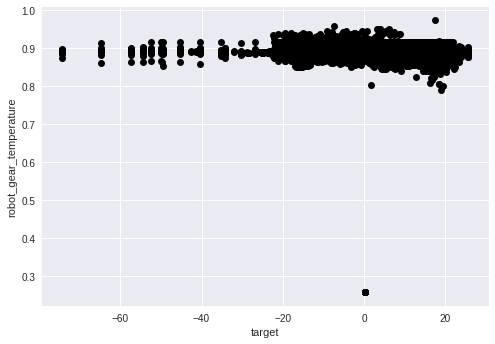

In [0]:
# Визуализация данных Таргет и некоторый столбец i

i=13#вводим номер столбца
plt.plot(dtrain_scaled ['target'],dtrain_scaled[list(dtrain_scaled)[i]],'o',color='black')
plt.xlabel('target')
plt.ylabel(list(dtrain_scaled)[i])

,year,target,gamma_ray,sensor_robot_controller_index,sensor_robot_arm_right,robot_gear_circulation,sensor_robot_arm_left,sensor_robot_jump_power,robot_gear_coef,robot_gear_compression,...,robot_engine_speed,robot_engine_circulation,robot_engine_ground,robot_engine_compression,robot_engine_temperature,sensor_robot_eye_laser_range,robot_probe_compression_diff,robot_probe_circulation,robot_probe_temperature,robot_gear_compression_diff
0,2019.0,19.993461,0.0,0.918820,0.776697,0.798153,0.570283,0.590369,0.064223,0.458926,...,0.130461,0.365642,0.375521,0.721686,0.702076,0.839158,0.628225,0.932950,0.644821,0.455139
1,2019.0,19.993461,0.0,0.941221,0.854387,0.788919,0.746806,0.458959,0.064223,0.452750,...,0.130461,0.359591,0.375521,0.737290,0.705231,0.668521,0.670164,0.921802,0.678353,0.440129
2,2019.0,19.993461,0.0,0.986036,0.789666,0.792075,0.812722,0.587161,0.064223,0.470747,...,0.130461,0.362899,0.375521,0.745437,0.715143,0.753840,0.665552,0.914774,0.668648,0.461723
3,2019.0,19.993461,0.0,0.957385,0.805889,0.792075,0.634259,0.669174,0.064223,0.415345,...,0.130461,0.386411,0.375521,0.734805,0.734534,0.753840,0.672176,0.929798,0.667033,0.415345
4,2019.0,19.993461,0.0,0.987261,0.808461,0.792075,0.745840,0.595351,0.064223,0.436771,...,0.130461,0.365642,0.375521,0.734805,0.718397,0.753840,0.641489,0.923043,0.657399,0.440129


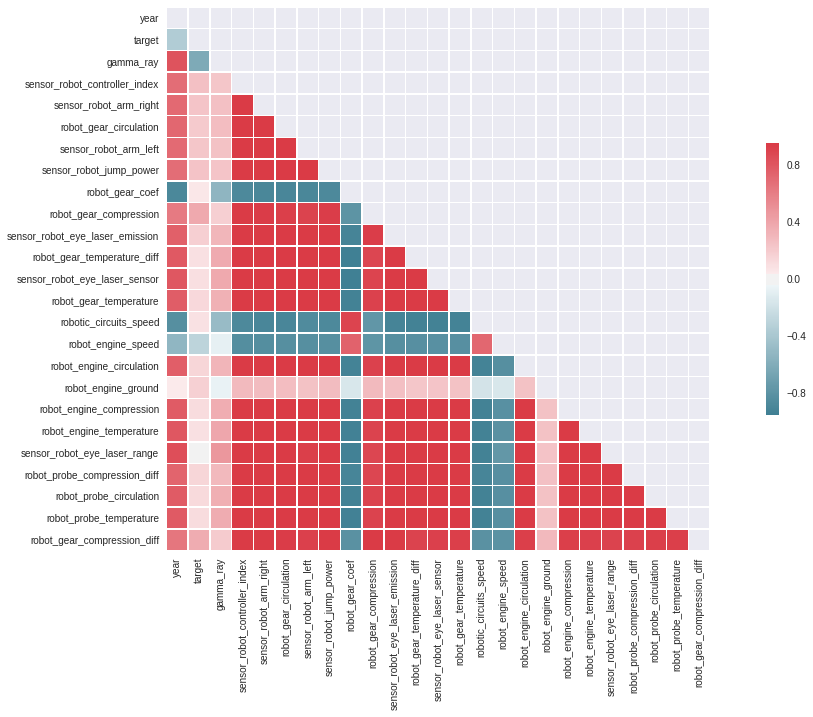

In [0]:
#белое - хорошо, красное и зеленое - плохо
import seaborn as sns
corr=dtrain_scaled.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 10))

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.95, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
dtrain_scaled.head(5)

In [0]:
#Основная обработка dtest
pd.unique(dtest['gamma_ray']) 
gamma_ray_cat=dtest['gamma_ray'].map({'low':0, 'moderate':1, 'high':2,'very high':3})#переводим категориальные в числовые +один признак
dtest['gamma_ray']=gamma_ray_cat
cols=dtest.columns.tolist()
swap1=cols[1]
cols[1]=cols[-2]
cols[-2]=swap1
cols=cols[-1:]+cols[:-1] 
dtest1=dtest[cols].copy()
dtest1['gamma_ray']=gamma_ray_cat

In [0]:
Result=dtest1.copy()
Result=Result.drop('target',1)

for i in range(0,max(Result.gamma_ray.index)+1):
    Result.gamma_ray[i]=Result.gamma_ray[0]

Result.head(10)

,year,gamma_ray,sensor_robot_controller_index,sensor_robot_arm_right,robot_gear_circulation,sensor_robot_arm_left,sensor_robot_jump_power,robot_gear_coef,robot_gear_compression,sensor_robot_eye_laser_emission,...,robot_engine_speed,robot_engine_circulation,robot_engine_ground,robot_engine_compression,robot_engine_temperature,sensor_robot_eye_laser_range,robot_probe_compression_diff,robot_probe_circulation,robot_probe_temperature,robot_gear_compression_diff
0,5282.0,2.0,0.517951,-6.143792,-12.470963,154.407496,-2.388320,-7.2484,-17.798846,-53.462931,...,-9.441785,1.016203,-34.393056,0.513557,8.859337,1.223251,36.381452,7.687685,28.990893,-18.136584
1,5282.0,2.0,-18.926809,-49.841173,-30.007996,7.321099,4.739531,-7.2484,-15.803555,7.139667,...,-9.441785,-3.798114,-34.393056,16.266168,37.613241,0.166366,-42.297385,1.378517,5.701576,-21.152350
2,5282.0,2.0,-51.644836,3.796236,-15.186654,-20.603060,0.769635,-7.2484,-29.772577,-4.152484,...,-9.441785,-11.846218,-34.393056,4.968681,33.405286,0.694808,11.521393,1.598877,17.471141,-20.810190
3,5282.0,2.0,-47.922514,-14.934904,-15.186654,15.791951,-60.504010,-7.2484,-26.048782,-2.622068,...,-9.441785,12.462098,-34.393056,7.249469,-13.056554,0.694808,-26.081840,48.858999,8.954441,-26.048782
4,5282.0,2.0,-53.402738,-37.594130,-15.186654,-16.906210,-11.454246,-7.2484,-23.105995,-13.274454,...,-9.441785,1.016203,-34.393056,7.249469,58.997182,0.694808,-0.041467,51.612485,4.094611,-21.152350
5,5282.0,2.0,-34.275789,-20.943553,-45.340762,28.002255,-13.767482,-7.2484,-27.578306,-13.274454,...,-9.441785,-0.784865,-34.393056,7.249469,3.199255,0.694808,-0.300998,1.916758,8.153749,-13.271357
6,5282.0,2.0,-34.275789,-20.943553,-15.186654,28.002255,-13.767482,-7.2484,-22.288341,-13.274454,...,-9.441785,3.440235,-34.393056,7.249469,8.859337,0.694808,-3.784241,0.350105,2.556148,-22.288341
7,5282.0,2.0,-34.275789,-20.943553,-46.915088,28.002255,-13.767482,-7.2484,-19.924976,-13.274454,...,-9.441785,6.624083,-34.393056,7.249469,8.859337,0.694808,-11.931894,11.362401,3.212842,-19.924976
8,5282.0,2.0,-34.275789,-20.943553,-15.186654,28.002255,-13.767482,-7.2484,-17.556931,-13.274454,...,-9.441785,1.016203,-34.393056,7.249469,28.581670,0.694808,-4.997090,0.682378,1.454573,-17.556931
9,5282.0,2.0,-34.275789,-20.943553,-15.186654,28.002255,-13.767482,-7.2484,-31.181639,-13.274454,...,-9.441785,1.016203,-34.393056,7.249469,53.736109,0.694808,13.863797,1.935840,8.954441,-31.181639


In [0]:
#считаем VIf 
from statsmodels.stats.outliers_influence import variance_inflation_factor    # Просто так не запускать, считает не оч БЫСТРО

def calculate_vif(X, thresh=5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped = True

    print('Remaining variables:')
    print(X.columns[variables])
    return X.iloc[:, variables]

vif_columns=list(calculate_vif(dtrain_scaled)) #извлекаем колонки

dropping 'robot_probe_circulation' at index: 22
dropping 'robot_gear_temperature' at index: 13
dropping 'robot_probe_temperature' at index: 21
dropping 'robot_engine_compression' at index: 17
dropping 'robot_engine_circulation' at index: 15
dropping 'sensor_robot_eye_laser_sensor' at index: 12
dropping 'robot_engine_temperature' at index: 15
dropping 'sensor_robot_arm_right' at index: 4
dropping 'sensor_robot_controller_index' at index: 3
dropping 'sensor_robot_eye_laser_emission' at index: 8
dropping 'robot_gear_compression_diff' at index: 14
dropping 'robot_gear_temperature_diff' at index: 8
dropping 'robot_gear_circulation' at index: 3
dropping 'sensor_robot_eye_laser_range' at index: 10
dropping 'sensor_robot_jump_power' at index: 4
dropping 'sensor_robot_arm_left' at index: 3
dropping 'robot_gear_compression' at index: 4
dropping 'robotic_circuits_speed' at index: 4
dropping 'year' at index: 1
dropping 'robot_engine_speed' at index: 3
dropping 'robot_probe_compression_diff' at ind

In [0]:
#Делаем сплит, чтобы посчитать r^2 (здесь индесы перемешаются)
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(dtrain_scaled.drop('target',1), dtrain_scaled.target, test_size=0.3, random_state=42)

In [0]:
#Если хотим отбросить по vif, то запускаем эту ячейку (если не запускали calculate_vif, то и эта ячейка не будет работать)
X_train=X_train.loc[:,vif_columns]
X_test=X_test.loc[:,vif_columns]
Result=Result.loc[:,vif_columns]

In [0]:
#ЭТО xgboost только на части данных, котрый мы разделили треин сплитом
import xgboost
xgb = xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=20)
model=xgb.fit(X_train.values,y_train.values)

y_pred=model.predict(X_test.values) #предсказываем сплит
model.score(y_pred,y_test)

#  # read in data
#  xgtrain = xgb.DMatrix(X_train.values, y_train.values)
#  xgtest = xgb.DMatrix(X_test.values)
#  # specify parameters via map
#  param = {'booster': 'dart',
#           'max_depth': 5, 'learning_rate': 0.1,
#           'objective': 'binary:logistic', 'silent': True,
#           'sample_type': 'uniform',
#           'normalize_type': 'tree',
#           'rate_drop': 0.1,
#           'skip_drop': 0.5}
# num_round = 50
# bst = xgb.train(param, X_train,list(X_train), num_round)
#  make prediction
#  ntree_limit must not be 0
# preds = bst.predict(dtest, ntree_limit=num_round)

In [0]:
# Это xgboost на всех тренировочных данных
import xgboost
xgb = xgboost.XGBRegressor(n_estimators=1000, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=20)
model2=xgb.fit(dtrain_scaled.drop('target',1).values,dtrain_scaled.target.values)


#  # read in data
#  xgtrain = xgb.DMatrix(X_train.values, y_train.values)
#  xgtest = xgb.DMatrix(X_test.values)
#  # specify parameters via map
#  param = {'booster': 'dart',
#           'max_depth': 5, 'learning_rate': 0.1,
#           'objective': 'binary:logistic', 'silent': True,
#           'sample_type': 'uniform',
#           'normalize_type': 'tree',
#           'rate_drop': 0.1,
#           'skip_drop': 0.5}
# num_round = 50
# bst = xgb.train(param, X_train,list(X_train), num_round)
#  make prediction
#  ntree_limit must not be 0
# preds = bst.predict(dtest, ntree_limit=num_round)

In [0]:
y_pred=model.predict(X_test.values) #предсказываем спли
y_pred2=model2.predict(Result.values)
model.score(y_pred,y_test)

In [0]:
new_Dict={'target':y_pred2}
new_Dict1={'year':Result.year[0].values}
new_DataFrame=pd.DataFrame(new_Dict1)
new_DataFrame.year=new_DataFrame.year.astype(int)
new_DataFrame.head(10)

In [0]:
new_DataFrame1=pd.DataFrame(new_Dict)
new_DataFrame1

In [0]:
j=[]
new_column=[]
for i in range(1,len(y_pred2)):
  if not i%27==0:
    j+=y_pred2[i]
  else:
    new_value=sum(j)/28
    new_column+=new_value

In [0]:
y_pred2

In [0]:
from sklearn.metrics import explained_variance_score
explained_variance_score(y_pred,y_test)

In [0]:
plt.plot(X_train.values[:,1],y_pred,'o',color='black')
plt.xlabel('year')
plt.ylabel('target')

In [0]:
y_pred_Result=res.predict(Result)

In [0]:
dtest1 = pd.read_csv('test_data.csv')
dtest1['target']=y_pred_Result
dtest2=pd.DataFrame(dtest1.loc[:,{'year','target'}],index=None) 
cols=list(dtest2)
cols1=cols[-1:]+cols[:1] #меняю столбцы местяами, тк почему-то мне автоматически выгружает в другом порядке
dtest2.loc[:,cols1].head(10)

In [0]:
dtest2[cols1].to_csv("Results.csv",index=False)#выгружаем csv

####Обработка MinMaxScaler

from sklearn import preprocessing 
dtrain_scaled=dtrain.copy()
x=dtrain_scaled.values[:,3:] #первые три не нормализуем
min_max_scaler=preprocessing.MinMaxScaler()
x_scaled=min_max_scaler.fit_transform(x)
dtrain_scaled.loc[:,3:]=x_scaled
dtrain_scaled 
from sklearn import preprocessing
x=dtrain_scaled.values[:,2:]
x_scaled=preprocessing.normalize(x)
dtrain_scaled.loc[:,2:]=x_scaled
dtrain_scaled


####Попытка перевести столбик year во время (заменяет стобик индекса) для обучения объединенной регрессии, но ошибка в том, в pd зашиты ограничения на минмакс возможные года, и мы выходим за лимиты.

model['year']=pd.to_datetime(model['year'], errors='coerce',format='%Y')#проблема в том, что будет out of bonds при попытке уйти дальше 2262 года, а coerce заменит все на NA
model=model.set_index('year', append=True)
####swap indexes
model.index = model.index.swaplevel(0,1)
print(model.head())

####Объединенная регрессия с обоими эффектами

from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from linearmodels import PooledOLS
from linearmodels import RandomEffects
dependent=model['target']
exog_entity=model[list(model)[1:]]
mod=PanelOLS(dependent, exog_entity,entity_effects=True, time_effects=True, other_effects=None)
res = mod.fit(cov_type='clustered', cluster_entity=True)
print(res)

####Попытка в нейросеть, но нужно привести в норму слои и размерность входящего вектора.
from keras.models import Sequential
from keras.layers import Dense
from sklearn.datasets import make_regression

model = Sequential()
model.add(Dense(3226, input_dim=2, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.fit(xtr, ytr, epochs=1000, verbose=0)